## 코드출처:데이콘 코드 공유 https://dacon.io/competitions/official/136/codeshare/1383?page=1&dtype=recent&ptype=pub


## facebook prophet 
*   https://zzsza.github.io/data/2019/02/06/prophet/
*   https://facebook.github.io/prophet/

##요소


*   Capacities : 시계열 데이터 전체의 최대값
*   Change Points : 추세가 변화하는 시점
*   Holidays & Seasonality : 추세에 영향을 미치는 시기적 요인

  *   Holidays

    *   주기성을 가지진 않지만 전체 추이에 큰 영향을 주는 이벤트
    


  *   Seasonality
    * 사용자들의 행동 양식으로 주기적으로 나타나는 패턴(방학, 휴가, 온도, 주말 등)
    * 푸리에 급수(Fourier Series)를 이용해 패턴의 근사치를 찾음

*   Smoothing : 각각의 요소들이 전체 추이에 미치는 영향의 정도


In [ ]:
!unzip data01.zip

Archive:  data01.zip
replace submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: submission.csv          
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    


In [ ]:
!unzip test.csv.zip

Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.csv                
  inflating: __MACOSX/._test.csv     


In [ ]:
train['date']=pd.to_datetime(train['date'],format='%Y-%m-%d')

In [ ]:
train['date'].dt.year

0          2016
1          2016
2          2016
3          2016
4          2016
           ... 
3362791    2018
3362792    2018
3362793    2018
3362794    2018
3362795    2018
Name: date, Length: 3362796, dtype: int64

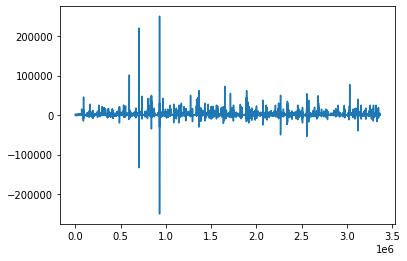

In [ ]:
train['amount'].plot()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import datetime
import os

import xgboost as xgb
from sklearn.model_selection import train_test_split
import lightgbm
import warnings
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
warnings.filterwarnings('ignore')
#한글 깨짐방지
plt.rc('font',family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [ ]:

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission  = pd.read_csv('submission.csv')
merge_df = pd.concat([train,test])

In [ ]:
train

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0
...,...,...,...,...,...,...,...,...
3362791,1799,2018-07-19,17:58:31,e254bf70d9,600,NaN,3,0
3362792,1799,2018-07-19,18:54:34,8f41c89891,275,NaN,3,0
3362793,1799,2018-07-22,14:46:57,aeb64fe1fb,350,NaN,6,0
3362794,1799,2018-07-25,18:09:13,57932602d6,300,NaN,2,0


In [ ]:
test

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-08-01,00:28:15,bf33518373,125,NaN,0,0
1,0,2016-08-01,01:09:58,7a19a3a92f,90,NaN,0,0
2,0,2016-08-01,01:47:24,6f9fd7e241,150,NaN,0,0
3,0,2016-08-01,17:54:43,8bcf1d61b2,362,NaN,0,0
4,0,2016-08-01,18:48:53,6a722ce674,125,NaN,0,0
...,...,...,...,...,...,...,...,...
473387,199,2018-03-30,14:17:59,300d7bc922,65,NaN,4,0
473388,199,2018-03-30,19:01:54,3ab757718b,65,NaN,4,0
473389,199,2018-03-30,20:08:03,2d8e9e421c,65,NaN,4,0
473390,199,2018-03-30,20:11:58,22daeb334e,200,NaN,4,0


In [ ]:
merge_df

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0
...,...,...,...,...,...,...,...,...
473387,199,2018-03-30,14:17:59,300d7bc922,65,NaN,4,0
473388,199,2018-03-30,19:01:54,3ab757718b,65,NaN,4,0
473389,199,2018-03-30,20:08:03,2d8e9e421c,65,NaN,4,0
473390,199,2018-03-30,20:11:58,22daeb334e,200,NaN,4,0


In [ ]:
#전체날짜의 휴일 요일
all_dates = merge_df.drop_duplicates('date').sort_values('date')
all_dates = all_dates[['date','days_of_week','holyday']]
all_dates.reset_index(drop=True, inplace=True)
all_dates['date'] = pd.to_datetime(all_dates['date'])
all_dates


,date,days_of_week,holyday
0,2016-08-01,0,0
1,2016-08-02,1,0
2,2016-08-03,2,0
3,2016-08-04,3,0
4,2016-08-05,4,0
...,...,...,...
725,2018-07-27,4,0
726,2018-07-28,5,0
727,2018-07-29,6,0
728,2018-07-30,0,0


In [ ]:
holidays = all_dates[all_dates['holyday'] >0][['date','holyday']]
holidays.columns = ['ds','holiday']
#holiday앞뒤로 window범위를 지정해 해당 이벤트가 미치는 영향의 범위를 설정할 수 있음
#주변 날짜를 포함시키기 위해 lower_window, upper_window를 사용해 업데이트의 영향을 조절 가능
holidays['lower_window'] = 0
holidays['upper_window'] = 0

holidays.holiday = holidays.holiday.astype('str')
holidays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 14 to 681
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            37 non-null     datetime64[ns]
 1   holiday       37 non-null     object        
 2   lower_window  37 non-null     int64         
 3   upper_window  37 non-null     int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.4+ KB


In [ ]:
#휴일요일
holidays

,ds,holiday,lower_window,upper_window
14,2016-08-15,1,0,0
44,2016-09-14,1,0,0
45,2016-09-15,1,0,0
46,2016-09-16,1,0,0
63,2016-10-03,1,0,0
69,2016-10-09,1,0,0
146,2016-12-25,1,0,0
153,2017-01-01,1,0,0
179,2017-01-27,1,0,0
180,2017-01-28,1,0,0


In [ ]:
#그냥 합산했을때 음수 발생하는 경우가 있음
d_sum = test.groupby(['date','store_id'])['amount'].sum().reset_index()
#groupby :그룹별 집계함수
d_sum[d_sum['amount']<0]
#d_sum


,date,store_id,amount
83,2016-08-02,1,-2500
190,2016-08-03,57,-675
7243,2016-10-21,129,-40
8576,2016-11-04,135,-9071
9958,2016-11-19,67,-1138
10254,2016-11-22,125,-198
12185,2016-12-12,179,-2600
12645,2016-12-17,89,-3250
14257,2017-01-03,73,-75
14946,2017-01-10,82,-145


In [ ]:
def del_minus(df):
    '''음수값을 처리하기 위함
    음수값을 처리할때 조건은, 동일 store_id, card_id이어야하며
    날짜는 minus보다 이전 날짜
    금액은 minus보다 큰 금액이어야 함

    위 조건을 만족하는 row가 여러개일 경우
    가장 최근의 날짜를 선택하되, 그 날짜가 이미 선택되어 있다면
    보다 이전날짜를 탐색하고, matching되지 않는다면 따로 분류

    속도를 원활하게 하기 위해 diction에 저장후 plus_amount_df와 매칭
    '''
    df['DT'] = pd.to_datetime(df['date']+" "+df['time'])
    minus_amount_df = df[df.amount<0][['DT','store_id','card_id','amount']]
    plus_amount_df = df[df.amount>0][['DT','store_id','card_id','amount']]

    err_dic = dict()
    not_match = []
    check_list = []
    err_dic[470565] = 0
    for i in tqdm(range(minus_amount_df.shape[0])):
        error_index = np.nan #초기화
        minus_index = minus_amount_df.iloc[i].name
        minus_card = minus_amount_df.iloc[i].card_id 
        minus_store = minus_amount_df.iloc[i].store_id
        minus_DT = minus_amount_df.iloc[i].DT
        minus_amount = minus_amount_df.iloc[i].amount

        try :
            range_df = plus_amount_df[plus_amount_df.store_id == minus_store] #동일 상점
            range_df = range_df[range_df.card_id == minus_card] #동일 카드
            range_df = range_df[range_df.DT <= minus_DT] #이전날짜
            range_df = range_df[range_df.amount.apply(lambda x : x >= abs(minus_amount))] #보다 큰 금액
            big_df = range_df[range_df.amount.apply(lambda x : x > abs(minus_amount))] #보다 큰 금액
            same_df = range_df[range_df.amount.apply(lambda x : x == abs(minus_amount))] #동일한 금액
        except :
            not_match.append(minus_index)
            pass

        #동일한 금액이 있는 경우
        if len(same_df)>=1:
            same_index = same_df.index
            error_index = same_index.max()  #최근날짜의 index를 추출
            if error_index in err_dic.keys(): #그 index가 이미 key값을 가지고 있는지 확인
                same_index = list(same_index)
                same_index.reverse()
                for dex in same_index[1:]: 
                    error_index = dex
                    if error_index not in err_dic.keys(): #key에 없는 값을 찾았다면 중단
                        break
                if error_index in err_dic.keys(): #모든 인덱스를 비교하고도 key값에 있다면 not_match에 저장
                    error_index = np.nan
                    not_match.append(minus_index)
            try :
                err_dic[error_index] = minus_amount
                check_list.append(error_index)
            except :
                pass

        #금액보다 더 큰 금액
        elif len(big_df)>= 1:
            big_index = big_df.index
            error_index = big_index.max()
            if error_index in err_dic.keys():
                big_index = list(big_index)
                big_index.reverse()
                for dex in big_index[1:]:
                    error_index = dex
                    if error_index not in err_dic.keys(): 
                        break
                if error_index in err_dic.keys():
                    error_index = np.nan
                    not_match.append(minus_index)
            try :
                err_dic[error_index] = minus_amount
                check_list.append(error_index)
            except :
                pass
        else : 
            not_match.append(minus_index) #매칭되는 것이 없다면 not_match에 넣어둔다 

    #최종정리
    plus_amount_df = df[df.amount>0]
    fin_minus= pd.DataFrame(index= err_dic.keys(),data=err_dic.values(), columns= ['minus']) 
    plus_amount_df = pd.merge(plus_amount_df,fin_minus,left_index=True, right_index=True,how = 'left')

    print(fin_minus)
    plus_amount_df['minus'].fillna(0,inplace = True)
    plus_amount_df['amount'] = plus_amount_df['amount'] + plus_amount_df['minus']
    plus_amount_df.drop('minus',axis=1,inplace=True)        
    return plus_amount_df

In [ ]:
#new_train = del_minus(train)
new_test = del_minus(test)


          minus
470565.0      0
206.0      -175
648.0      -175
888.0       -95
918.0      -165
...         ...
473113.0   -200
473191.0    -65
473201.0   -250
473331.0    -75
473355.0    -65

[7941 rows x 1 columns]


In [ ]:
new_test[new_test['amount']>0].head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,DT
0,0,2016-08-01,00:28:15,bf33518373,125.0,NaN,0,0,2016-08-01 00:28:15
1,0,2016-08-01,01:09:58,7a19a3a92f,90.0,NaN,0,0,2016-08-01 01:09:58
2,0,2016-08-01,01:47:24,6f9fd7e241,150.0,NaN,0,0,2016-08-01 01:47:24
3,0,2016-08-01,17:54:43,8bcf1d61b2,362.0,NaN,0,0,2016-08-01 17:54:43
4,0,2016-08-01,18:48:53,6a722ce674,125.0,NaN,0,0,2016-08-01 18:48:53


In [ ]:
train_grouped = new_train.groupby(['date','store_id'])['amount'].sum().reset_index()
train_grouped.store_id.nunique()
#nunique :중복된 것을 제외한 것의 갯수를 나타냄

1775

In [ ]:
Train=False

#하루로 묶어서 진행
#train데이터는 시간이너무 오래걸려서 원래코드대로 test데이터로 진행 ->때문에 성능이 매우 낮게 나온것 같다
train_grouped = new_test.groupby(['date','store_id'])['amount'].mean().reset_index()
y_reals = []
y_preds = []
store_ids = []
for i in tqdm(train_grouped.store_id.unique()):
    sample = train_grouped[train_grouped.store_id ==i]
    sample.drop('store_id',axis=1,inplace=True)
    
    if Train :
        sample['date'] = pd.to_datetime(sample['date'])
        sample.index= sample['date']
        sample.columns = ['ds','y']

        answer = sample.last('100D')
        train = sample[sample['ds'] < answer['ds'].iloc[0]]
        y_real = answer['y'].sum()
        y_reals.append(y_real)
    else :
        sample['date'] = pd.to_datetime(sample['date'])
        sample.columns = ['ds','y']
       
        test= sample
    #예측
    m = Prophet(
                holidays=holidays,
                changepoint_prior_scale=10,
                changepoint_range = 0.5,
                )

    m.add_seasonality(name='daily', period=1, fourier_order=15)
    m.add_seasonality(name='weekly',period=7, fourier_order=20)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=12)
    m.add_seasonality(name='quarterly', period=365.25/4,fourier_order=5, prior_scale=15)
    m.add_seasonality(name='yearly',period=365.25, fourier_order=20)

    
    m.fit(train)
    
    future = m.make_future_dataframe(periods=100)  
  
    forecast = m.predict(future)   
    y_pred = forecast.iloc[-100:, :].yhat.sum()
    y_preds.append(y_pred)
    store_ids.append(i)
    # 시각화부분
    #fig1 = m.plot(forecast)
    #plt.title(i)
    #plt.show()

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,1,1_lower,1_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,monthly,monthly_lower,monthly_upper,quarterly,quarterly_lower,quarterly_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-12-26,15.059215,-38.956018,46.083756,15.059215,15.059215,0.000000,0.000000,0.000000,-13.910614,-13.910614,-13.910614,903.331526,903.331526,903.331526,0.000000,0.000000,0.000000,-13.528521,-13.528521,-13.528521,-12.300489,-12.300489,-12.300489,114.049289,114.049289,114.049289,-1005.462418,-1005.462418,-1005.462418,0.0,0.0,0.0,1.148601
1,2017-12-29,17.066244,97.051628,179.093877,17.066244,17.066244,0.000000,0.000000,0.000000,116.870301,116.870301,116.870301,903.331526,903.331526,903.331526,0.000000,0.000000,0.000000,18.257143,18.257143,18.257143,31.363018,31.363018,31.363018,114.744564,114.744564,114.744564,-950.825950,-950.825950,-950.825950,0.0,0.0,0.0,133.936545
2,2017-12-30,17.735253,100.554120,185.765362,17.735253,17.735253,0.000000,0.000000,0.000000,125.480844,125.480844,125.480844,903.331526,903.331526,903.331526,0.000000,0.000000,0.000000,9.541530,9.541530,9.541530,37.747674,37.747674,37.747674,130.571994,130.571994,130.571994,-955.711879,-955.711879,-955.711879,0.0,0.0,0.0,143.216097
3,2017-12-31,18.404263,84.069974,166.727409,18.404263,18.404263,0.000000,0.000000,0.000000,106.714222,106.714222,106.714222,903.331526,903.331526,903.331526,0.000000,0.000000,0.000000,19.775922,19.775922,19.775922,41.397125,41.397125,41.397125,108.454779,108.454779,108.454779,-966.245130,-966.245130,-966.245130,0.0,0.0,0.0,125.118485
4,2018-01-01,19.073274,24.044960,107.397490,19.073274,19.073274,-24.990231,-24.990231,-24.990231,45.097535,45.097535,45.097535,903.331526,903.331526,903.331526,-24.990231,-24.990231,-24.990231,1.997818,1.997818,1.997818,43.320830,43.320830,43.320830,99.763814,99.763814,99.763814,-978.326223,-978.326223,-978.326223,0.0,0.0,0.0,64.170808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2018-07-05,-4146.907231,-6109.721247,-100.586667,-7195.290960,-1184.244247,0.000000,0.000000,0.000000,1071.728585,1071.728585,1071.728585,903.331526,903.331526,903.331526,0.000000,0.000000,0.000000,13.978956,13.978956,13.978956,46.709612,46.709612,46.709612,133.865051,133.865051,133.865051,-26.156560,-26.156560,-26.156560,0.0,0.0,0.0,-3075.178646
176,2018-07-06,-4168.737699,-6212.062548,-112.579013,-7253.787970,-1157.751049,0.000000,0.000000,0.000000,1040.458590,1040.458590,1040.458590,903.331526,903.331526,903.331526,0.000000,0.000000,0.000000,0.483246,0.483246,0.483246,49.646050,49.646050,49.646050,114.744564,114.744564,114.744564,-27.746795,-27.746795,-27.746795,0.0,0.0,0.0,-3128.279109
177,2018-07-07,-4190.568167,-6151.454729,67.677351,-7313.875705,-1129.528946,0.000000,0.000000,0.000000,1180.749531,1180.749531,1180.749531,903.331526,903.331526,903.331526,0.000000,0.000000,0.000000,122.338695,122.338695,122.338695,54.265551,54.265551,54.265551,130.571994,130.571994,130.571994,-29.758235,-29.758235,-29.758235,0.0,0.0,0.0,-3009.818637
178,2018-07-08,-4212.398636,-6293.587263,33.285305,-7387.694071,-1114.273657,0.000000,0.000000,0.000000,1117.376006,1117.376006,1117.376006,903.331526,903.331526,903.331526,0.000000,0.000000,0.000000,76.738686,76.738686,76.738686,60.762952,60.762952,60.762952,108.454779,108.454779,108.454779,-31.911938,-31.911938,-31.911938,0.0,0.0,0.0,-3095.022629


In [ ]:
result = pd.DataFrame(data={'store_id': store_ids, 'amount': y_preds}).sort_values('store_id')

In [ ]:
result

,store_id,amount
0,0,1.748548e+04
91,1,7.631384e+04
1,2,2.213104e+04
2,3,1.241553e+04
3,4,4.763814e+03
...,...,...
90,195,1.178012e+04
80,196,6.824347e+04
81,197,-7.232949e+06
109,198,-7.033893e+04


In [ ]:
submission['total_sales'] = result['amount']

In [ ]:
today = datetime.datetime.today().date()

In [ ]:
today

datetime.date(2021, 1, 11)

In [ ]:
submission.to_csv("result.csv",index=False)